<a href="https://colab.research.google.com/github/twice1st/Detecting-and-Beautifying-Vietnamese-Faces/blob/main/Source%20code/Face_Beautification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Inference__

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install mtcnn

     |████████████████████████████████| 2.3 MB 24.7 MB/s 


In [ ]:
from mtcnn import MTCNN
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
import pickle
import numpy as np

In [ ]:
modelnn = tf.keras.models.load_model('/content/drive/MyDrive/CS231/Model')
with open('/content/drive/MyDrive/CS231/knn.pkl', 'rb') as fid:
    knn = pickle.load(fid)
with open('/content/drive/MyDrive/CS231/svm.pkl', 'rb') as fid:
    svm = pickle.load(fid)

In [ ]:
path_emb_sm2 = "/content/drive/MyDrive/CS231/nn4.small2.v1.t7"
def _load_torch(model_path_fl):
  """
  model_path_fl: Link file chứa weigth của model
  """
  model = cv2.dnn.readNetFromTorch(model_path_fl)
  return model

encoder_sm2 = _load_torch(path_emb_sm2)

In [ ]:
def _blobImage(image, out_size = (300, 300), scaleFactor = 1.0, mean = (104.0, 177.0, 123.0)):

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  imageBlob = cv2.dnn.blobFromImage(image, 
                                    scalefactor=scaleFactor, 
                                    size=out_size,
                                    mean=mean,
                                    swapRB=False,
                                    crop=False)
  return imageBlob

In [ ]:
def _embedding_face(encoder, face):
    faceBlob = _blobImage(face, out_size = (96, 96), scaleFactor=1/255.0, mean=(0, 0, 0))
    # Embedding face
    encoder.setInput(faceBlob)
    vec = encoder.forward()
    return vec

In [ ]:
def pred_vnese(face,encoder=encoder_sm2,model=modelnn):
    # Phân loại người Việt trong bức ảnh
    embedding = _embedding_face(encoder,face)
    y_pred = (model.predict(embedding) > 0.5).astype("int32")
    y_pred= y_pred.reshape(y_pred.shape[0])
    return y_pred, model.predict(embedding)

In [ ]:
def Split(hsv_img):
  # Tách rời 3 kênh màu
    h,s,v = cv2.split(hsv_img)
    return h,s,v
def sobel_filters(face,blur_ksize=3, sobel_ksize=3):
  # Bộ lọc sobel theo hướng x,y để phát hiện da
    img_gaussian = cv2.GaussianBlur(face,(blur_ksize,blur_ksize),0)
    img_sobelx = cv2.Sobel(img_gaussian,cv2.CV_64F,1,0,ksize=sobel_ksize)
    img_sobely = cv2.Sobel(img_gaussian,cv2.CV_64F,0,1,ksize=sobel_ksize)
    return img_sobelx,img_sobely

In [ ]:
def Findskinmap(face,th_x=40,th_y=40):
  # Tìm vùng da
    sobel_x,sobel_y = sobel_filters(face)
    skin_map= face.copy()
    for row in range (face.shape[0]):
        for col in range (face.shape[1]):
            x_value= sobel_x[row,col]
            y_value= sobel_y[row,col]
            if (x_value<th_x) and (y_value<th_y) and ((pow(x_value,2)+pow(y_value,2))<(pow(th_x,2)+pow(th_y,2))):
                skin_map[row][col]=255
            else: 
                skin_map[row][col]=0
    return skin_map

In [ ]:
FaceDetection =MTCNN()

In [ ]:
import dlib
p = "/content/drive/MyDrive/CS231/demo/shape_predictor_68_face_landmarks (1).dat"
predictor = dlib.shape_predictor(p)

In [ ]:
def createBox(img,points,scale=5,masked=False,cropped = True):
    if masked:
        mask = np.zeros_like(img)    
        mask = cv2.fillPoly(mask,[points],(255,255,255))
        img = cv2.bitwise_and(img,mask)
    if cropped:
        bbox = cv2.boundingRect(points)
        x,y,w,h = bbox
        imgCrop = img[y:y+h,x:x+w]
        imgCrop = cv2.resize(imgCrop,(0,0),None,scale,scale)
        return imgCrop
    else:
        return mask

In [ ]:
def draw_box(img,label,acc,x,y,w,h):
    if label:
        color= (0,0,255)
        text= "Vietnamese "
    else:
        color= (255,0,0)
        text = "Other "
    text= text+ str(acc)
    img = cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
    cv2.putText(img, text, (x, y-10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.9, color, 1)
    return img

In [ ]:
def smooth_sobel(face):
  hsv_img= cv2.cvtColor(face, cv2.COLOR_RGB2HSV)
  hi,si,vi= Split(hsv_img)
  skin_map= Findskinmap(vi)
  x,y= sobel_filters(face)
  full_mask = cv2.merge((skin_map, skin_map, skin_map))
  blurred_img = cv2.bilateralFilter(face, 15, 70, 70)
  # Apply mask to image
  masked_img = cv2.bitwise_and(blurred_img, full_mask)
  # Invert mask
  inverted_mask = cv2.bitwise_not(full_mask)
  # Created anti-mask
  masked_img2 = cv2.bitwise_and(face, inverted_mask)
  # Add the masked images together
  smoothed_roi = cv2.add(masked_img2, masked_img)
  return smoothed_roi,full_mask
def Blending(img,face,face_pos):
  for row in range (face_pos[1],face_pos[1]+face.shape[0]):
    for col in range (face_pos[0],face_pos[0]+face.shape[1]):
      img[row,col]= face[row-face_pos[1],col-face_pos[0]]
  return img

In [ ]:
def smooth_hsv(detected_img):
        temp_img = detected_img.copy()
        # Convert roi_img to HSV colorspace
        hsv_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv_img)
        img_br = adj_brightness(v)
        hsv_img = cv2.merge((h,s,img_br))
        # Get the mask for calculating histogram of the object and remove noise
        hsv_mask = cv2.inRange(hsv_img, 
                               np.array((0.0, 75.0, 75.0)), 
                               np.array((100.0, 255.0, 255.0)))
        # Make a 3 channel mask
        full_mask = cv2.merge((hsv_mask, hsv_mask, hsv_mask))
        # Apply blur on the created image
        blurred_img = cv2.bilateralFilter(detected_img, 15, 70, 70)
        # Apply mask to image
        masked_img = cv2.bitwise_and(blurred_img, full_mask)
        # Invert mask
        inverted_mask = cv2.bitwise_not(full_mask)
        # Created anti-mask
        masked_img2 = cv2.bitwise_and(temp_img, inverted_mask)
        # Add the masked images together
        smoothed_roi = cv2.add(masked_img2, masked_img)
        return smoothed_roi,full_mask

In [ ]:
def adj_brightness(luminance):
    cols, rows = luminance.shape
    brightness = np.sum(img) / (255 * cols * rows)
    minimum_brightness = 1.5
    ratio = brightness / minimum_brightness
    if ratio >= 1:
        return luminance
    return cv2.convertScaleAbs(luminance, alpha = 1 / ratio, beta = 0)

In [ ]:
def makeup_lip(imgOriginal,lip):
    imgLips = createBox(imgOriginal,lip,3,masked=True,cropped=False)
    imgColorLips = np.zeros_like(imgLips)
    imgColorLips[:] = 0, 36, 164
    imgColorLips = cv2.bitwise_and(imgLips,imgColorLips)
    imgColorLips = cv2.GaussianBlur(imgColorLips,(7,7),10)
    imgOriginal = cv2.addWeighted(imgOriginal,1,imgColorLips,0.4,0)
    return imgOriginal,imgColorLips

In [ ]:
import matplotlib.pyplot as plt 
def show3image(img_src, img_rst, img_thr,title1, title2, title3):
    plt.figure(figsize = (40, 40))
    plt.subplot(1, 3, 1)
    plt.title(title1)
    img_src = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)
    img_src = plt.imshow(img_src, interpolation = 'bicubic')
    plt.subplot(1, 3, 2)
    plt.title(title2)
    img_rst = cv2.cvtColor(img_rst, cv2.COLOR_BGR2RGB)
    img_rst = plt.imshow(img_rst, interpolation = 'bicubic')
    plt.subplot(1, 3, 3)
    plt.title(title3)
    img_thr = cv2.cvtColor(img_thr, cv2.COLOR_BGR2RGB)
    img_thr = plt.imshow(img_thr, interpolation = 'bicubic')

In [ ]:
path= "/content/drive/MyDrive/CS231/demo/mun.jpg"
img= cv2.imread(path)
faces = FaceDetection.detect_faces(img)

In [ ]:
def Face_Beautification(img,model=modelnn,smooth=smooth_sobel):
    imgOriginal= img.copy()
    draw_img= img.copy()
    lm= img.copy()
    for face in faces:
        (x, y, w, h)= face["box"]
        face_pos= [x,y]
        face_img = imgOriginal[y:y+h,x:x+w]
        label,acc= pred_vnese(face_img,model=model)
    if label:
        box= dlib.rectangle(left=x, top=y, right=x+w, bottom=y+h)
        face_img,full_mask= smooth(face_img)
        imgOriginal = Blending(imgOriginal,face_img,face_pos)
        # phần này là vẽ các thứ các thứ
        landmark = predictor(imgOriginal,box) 
        myPoints=[]
        for idx,point in enumerate(landmark.parts()):
            myPoints.append([point.x,point.y])
            cv2.circle(lm,(point.x,point.y),1,(0,255,0),1)
            cv2.putText(lm,str(idx),(point.x,point.y),fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                fontScale=0.4,
                color=(0, 0, 255))
        lip_1= myPoints[48:55]
        for i in myPoints[64:60:-1]:
            lip_1.append(i)
        lip_2= [myPoints[48],myPoints[60]]
        for i in myPoints[68:64:-1]:
            lip_2.append(i)
        for i in myPoints[54:60]:
            lip_2.append(i)
        lip_1= np.array(lip_1)
        lip_2= np.array(lip_2)
    
        imgOriginal,lip11= makeup_lip(imgOriginal,lip_1)
        imgOriginal,lip12= makeup_lip(imgOriginal,lip_2)
        imgLips1 = createBox(imgOriginal,lip_1,8,masked=True,cropped=False)
        imgLips2 = createBox(imgOriginal,lip_2,8,masked=True,cropped=False)
    draw_img=draw_box(draw_img,label,acc[0],x,y,w,h)
    show3image(img,draw_img, imgOriginal,"Resource", "Classification", "Result")

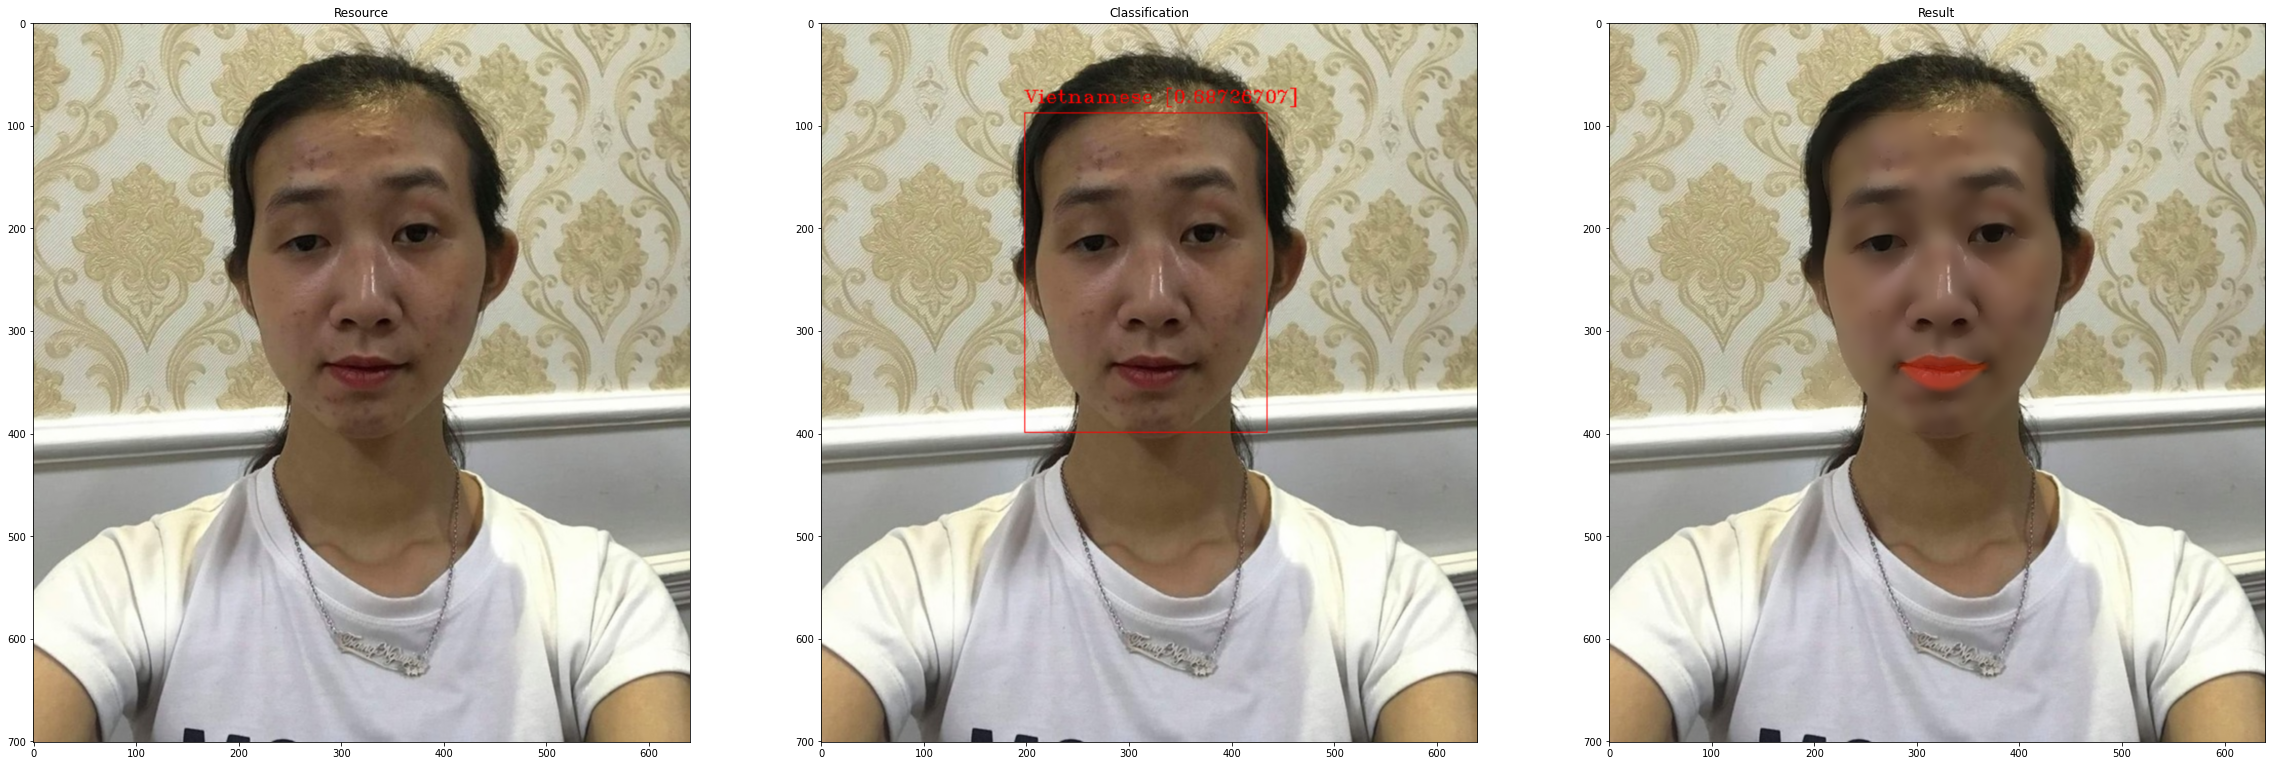

In [ ]:
Face_Beautification(img)

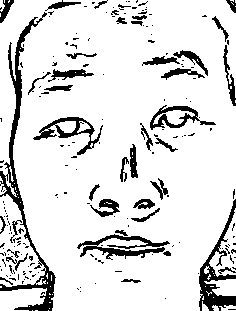

In [ ]:
cv2_imshow(full_mask)

In [ ]:
print("123")